# Лабораторная работа № 6. Ансамблевые модели для прогнозирования температуры блока усиления мощности.

В работе проводится обзор основных ансамблевых моделей машинного обучения по прогнозированию временного ряда. В качестве примера рассмотрена температура блока усиления мощности.

## Введение

Современные радиолокационные станции (РЛС) – это структурно-сложные радиотехнические и информационные системы, характеризующиеся высокой надежностью функционирования и большим числом цифровых компонентов в своем составе. Одним из таких компонентов является блок усиления мощности (БУМ), задача которого усиливать передаваемый или принимаемый сигнал.

Функционирование БУМ приводит к их нагреву, что может сказаться на снижении их работоспособности или даже привести к отказу.  Техническое состояние БУМ напрямую зависит от их температуры: при достижении определенного порога блок перестает работать и начинает охлаждаться. После охлаждения до определенной температуры он снова переходит в рабоспособное состояние.

Основная задача, решаемая в рамках данной лабораторной работы - спрогнозировать будущее значение температуры блоков усиления мощности на основании истории их функционирования и режима работы блоков. Последний определяет тип сигнала, передаваемый на БУМ, а поэтому определяет интенсивность нагрева.

Существует 2 основных подхода к прогнозированию временного ряда методами машинного обучения. В обоих подходах обучающая выборка состоит из ретроспективных данных о функционировании блока. Отличие состоит в том, что выбирается в качестве целевой переменной. 

В первом подходе определяется значение временного ряда (температуры) на следующем отсчете времени (целевая переменная - 1-мерная). Тогда прогнозные значения на каком-то интервале времени будут получаться путем последовательного прогнозирования значения ряда на 1 временной отсчет. При этом ошибка неизбежно накапливается, поскольку каждое прогнозное значение имеет свою неустранимую ошибку.

В другом подходе в качестве целевой переменной выбирается сразу интервал значений длиной *n* (целевая переменная *n*-мерная). Такой подход лишен недостатка в виде накопления ошибки, как в первом подходе. Однако, в этом случае сам метод прогнозирования сложнее и требует больших временных затрат и больших вычислительных мощностей.

В данной лабораторной работе мы остановимся на первом подходе.

## Описание файла с данными

Подключим стандартные пакеты для работы с данными и построения графиков

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
%matplotlib inline

Загрузим файл с данными и выведем на экран первые 5 строк. Получим информацию по каждой колонке.

In [ ]:
start_time = time.time()

In [ ]:
df = pd.read_csv("Lab6_data.csv")
df.head()

,mode,temp1,temp2,temp3
0,3,28.286114,28.043155,27.282141
1,4,34.142434,35.346311,34.829661
2,2,34.813586,36.781106,34.445407
3,4,39.946499,43.133120,40.372435
4,4,43.950857,47.014358,44.162152


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205950 entries, 0 to 1205949
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   mode    1205950 non-null  int64  
 1   temp1   1205950 non-null  float64
 2   temp2   1205950 non-null  float64
 3   temp3   1205950 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 36.8 MB


Первая колонка **mode** обозначает номер режима работы блоков. Этот режим определяет интенсивность нагрева блоков. Анализ каждого из режимов был выполнен в предыдущей лабораторной работе. Следующие 3 колонки в датасете содержат в себе информацию о температуре каждого из 3-х БУМ в каждый момент времени.

Для простоты рассмотрим только 1-й блок и будем прогнозировать только его температуру.

In [ ]:
df = df[['mode','temp1']].rename(columns={'temp1':'temp'})

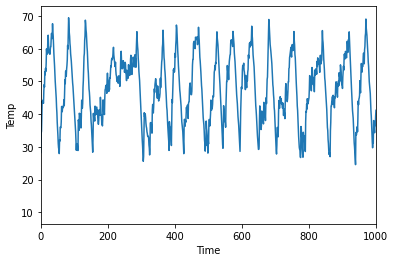

In [ ]:
plt.plot(df['temp'])
plt.xlim(0,1000)
plt.xlabel('Time')
plt.ylabel('Temp')
plt.show()

## Подготовка данных

### Нормирование

Температура, записанная в таблице **df** измеряется в градусах Цельсия. Однако для применения различных моделей машинного обучения желательно нормировать данные, чтобы ограничить их максимальные и минимальные значения. Отнормируем значения температуры на отрезок \[0,1\]. Сохраненные значения **max_value** и **min_value** позволят после выполнения прогноза вернуться к реальным значениям температуры.  

In [ ]:
def normalize(series):
    # Напишите свой код здесь
    max_value = np.max(df['temp'])
    min_value = np.min(df['temp'])
    normalized = (df['temp'] - min_value)/(max_value - min_value)
    return normalized, max_value, min_value

In [ ]:
normalized, max_value, min_value = normalize(df['temp'])
df.loc[:,'temp'] = normalized

In [ ]:
df

,mode,temp
0,3,0.310763
1,4,0.407675
2,2,0.418782
3,4,0.503723
4,4,0.569988
...,...,...
1205945,2,0.156166
1205946,4,0.323197
1205947,2,0.340362
1205948,0,0.311810


### Создание тестовой выборки

В качестве тестовой выборки будем использовать последовательность значений температур определенной длины **seq_length** и режим работы в конце этой последовательности. При этом стоит обратить внимание на то, что режим работы в какой-то временной отсчет $mode_i$ определяет значение температуры в тот же самый отсчет времени $T_i$. Поэтому обучающая выборка должна состоять из значений:

$$
X = \{T_{N-seq\_length+1}, ..., T_{N-1}, T_{N}, mode_{N+1}\}.
$$

В то время как целевая переменная является просто последующим значением температуры:

$$
y = T_{N+1}.
$$

Воспользуемся функцией, написанной в прошлой лабораторной работе, которая будет создавать обучающую и тестовую выборку объемом **N**, где длина обучающей последовательности равна **seq_length**.

In [ ]:
def get_sequences(df, N, seq_length):
    if N + seq_length > len(df) - 1:
        N = len(df) - seq_length - 1
    X = None
    y = None
    pos = 1
    while pos < N:
        seq = np.append(df.loc[pos:pos+seq_length-1, 'temp'].values, df.loc[pos+seq_length, 'mode'].astype('float64'))
        X = np.vstack((X, seq)) if X is not None else seq
        y_val = df.loc[pos+seq_length, 'temp'].astype('float64')
        y = np.append(y, y_val) if y is not None else np.array(y_val)
        pos += 1
    return X, y

Создадим обучающую и тестовую выборки

In [ ]:
size = 10000
seq_length = 40

X, y = get_sequences(df, size, seq_length)

## Ансамблевые модели машинного обучения

Мотивация применения ансамблевых методов состоит в том, чтобы объединить прогнозы нескольких базовых моделей, построенных с заданным алгоритмом обучения и улучшить качество прогноза.

Обычно выделяют два семейства ансамблевых методов:

- в методах усреднения (бэггинга) главный принцип состоит в том, чтобы построить несколько моделей независимо, а затем усреднить их прогнозы. В среднем, комбинированная оценка обычно лучше, чем любая из оценок отдельной модели, потому что дисперсия ее ошибки прогноза уменьшается.

- в методах бустинга базовые модели строятся последовательно, и каждая пытается уменьшить ошибку прогноза предыдущей модели. Идея состоит в том, чтобы объединить несколько слабых моделей для создания мощного ансамбля. 

## Бэггинг

В ансамблевых алгоритмах бэггинга создается несколько экземпляров базовой модели на случайных подмножествах исходной обучающей выборки, а затем агрегируются индивидуальные прогнозы этих моделей для формирования окончательного прогноза. Такой подход используется как способ уменьшить дисперсию базовой модели (например, дерева решений) путем введения случайности в процедуру построения моделей и последующего создания из них ансамбля. Во многих случаях методы бэггинга представляют собой очень простой способ улучшения базовой модели, без необходимости ее специальной настройки. Поскольку бэггинг обеспечивает способ уменьшения переобучения, этот подход лучше всего работает с сильными и сложными моделями (например, полностью разработанными деревьями решений), в отличие от методов бустинга, которые обычно лучше всего работают со слабыми моделями (например, с неглубокими деревьями решений).

Методы бэггинга бывают разных видов, но в основном отличаются друг от друга тем, как они создают случайные подмножества обучающей выборки:

- метод вставки - обучающие выборки создаются как случайные подмножества исходной выборки.

- метод бутстрэпа - обучающие выборки создаются как исходная выборка с повторениями, т.е. некоторые, случайные элементы исходной выборки дублируются.

- метод случайного подпространства - обучающие выборки создаются как случайные подмножества признаков.

- метод случайных исправлений - базовые модели обучаются на подмножествах как исходной обучающей выборки, так и признаков.

### Создание обучающей выборки методом бутстрэпа

Реализуйте метод формирования обучающих выборок бутстрэпом. Функция **get_bootstrap_samples(data_X, data_y, n_samples)** принимает на вход исходную выборку **data_X, data_y** и число выходных обучающих выборок **n_samples**, а возвращает совокупность обучающих выборок размером **(n_samples, len(data_X))**. Внутри функции необходимо случайным образом из исходной выборки **n_samples** раз выбрать элементы (с повторениями).

In [ ]:
def get_bootstrap_samples(data_X, data_y, n_samples):
    # Напишите здесь свой код
    r_value = [np.random.choice(range(0,len(X_train)), size = 8000, replace = True) for i in range(n_samples)]
    samples_X = X_train[r_value]
    samples_y = y_train[r_value]

    print('len = ',len(samples_X),'samples_X=',samples_X)
    print('len = ',len(samples_y),'samples_y=',samples_y)

    return (samples_X, samples_y)

Реализуйте функцию **regr_mape(y_pred, y_test)**, которая подсчитывает значение метрики **MAPE** (Mean Absolut Percentage Error - средняя абсолютная ошибка) для прогнозных **y_pred** и истинных значений **y_test** температуры. Также реализуйте функцию **train(model, model_name, evaluate, X_train, y_train, X_test, y_test)**, которая будет обучать заданную модель **model**. Переменная **evaluate** обозначает метод, который используется для оценки точности прогнозных значений (например, **regr_mape()**). Функция **train()** должна выдавать на выходе значение точности прогноза на обучающей выборке, точности прогноза на тестовой выборке и массив самих прогнозных значений. 

In [ ]:
def regr_mape(y_pred, y_test):
    # Напишите здесь свой код
    N = np.size(y_test)
    flat_array = y_pred.flatten()
    flat_array1 = y_test.flatten()
    mape = np.sum(abs( (y_test-y_pred))/y_test)/N

    return mape

def train(model, model_name, evaluate, X_train, y_train, X_test, y_test):
    # Напишите здесь свой код
    print('Train model: '+model_name)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    #print('y_pred_train=',y_pred)
    #print('y_train=',y_train)
    score_train = evaluate(y_pred, y_train)
    
    y_pred = model.predict(X_test)
    #print('y_pred_test=',y_pred)
    #print('y_test=',y_test)
    score_test = evaluate(y_pred, y_test)



    print('score_test = {:.5f}'.format(score_test))
    print('score_train = {:.5f}'.format(score_train))

    return (score_train, score_test, y_pred)

Создайте 1000 обучающих выборок и обучите на них 1000 моделей **DecisionTreeRegressor** с оптимальными параметрами, найденными в предыдущей лабораторной работе. Затем получите прогнозы температуры для тестовой выборки.

In [ ]:
n_samples = 1000
train_len = 8000
X_train = X[:train_len]
y_train = y[:train_len]
X_test = X[train_len:]
y_test = y[train_len:]

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=9, min_samples_split=3, min_samples_leaf=2, random_state=0)

results = get_bootstrap_samples(X_train, y_train, n_samples)


len =  1000 samples_X= [[[0.86289772 0.84061258 0.8920341  ... 0.61683632 0.60677026 1.        ]
  [0.83047665 0.84707988 0.89975364 ... 0.74913457 0.72354243 0.        ]
  [0.83466241 0.80904426 0.88383089 ... 0.52866993 0.61410332 2.        ]
  ...
  [0.50098724 0.57620722 0.58477197 ... 0.89543734 0.85869533 4.        ]
  [0.59673106 0.5967016  0.59200183 ... 0.87570624 0.85983551 0.        ]
  [0.60491992 0.57199011 0.58555409 ... 0.88668495 0.84362824 0.        ]]

 [[0.66851627 0.68399417 0.69132628 ... 0.91030228 0.88540308 1.        ]
  [0.48638549 0.48264896 0.4603354  ... 0.77036436 0.74854432 4.        ]
  [0.50269962 0.48733353 0.55022532 ... 0.45871107 0.43984225 4.        ]
  ...
  [0.6112885  0.6456993  0.6028176  ... 0.49763027 0.46246513 1.        ]
  [0.39669871 0.35667573 0.30914143 ... 0.31749495 0.45807959 3.        ]
  [0.68303878 0.65184885 0.61217934 ... 0.64555656 0.64518012 0.        ]]

 [[0.83437253 0.80022257 0.79080901 ... 0.41576098 0.41588279 2.        ]

In [ ]:
X_bootstrap,y_bootstrap = results
print(len(X_bootstrap))
print(len(X_bootstrap[0]))
print(len(X_bootstrap[0][0]))

1000
8000
41


In [ ]:
# Напишите здесь свой код

X_bootstrap,y_bootstrap = results

result = [train(dtr, 'dtr', regr_mape, X_bootstrap[indx], y_bootstrap[indx], X_test, y_test) for indx in range(n_samples)]
sc_tr,sc_test,predictions = [a_tuple[0] for a_tuple in result],[a_tuple[1] for a_tuple in result],[a_tuple[2] for a_tuple in result]

print('predictions=',predictions)    
predictions = np.asarray(predictions)

Train model: dtr
score_test = 0.02074
score_train = 0.01155
Train model: dtr
score_test = 0.02083
score_train = 0.01165
Train model: dtr
score_test = 0.02048
score_train = 0.01170
Train model: dtr
score_test = 0.02160
score_train = 0.01114
Train model: dtr
score_test = 0.02002
score_train = 0.01152
Train model: dtr
score_test = 0.02102
score_train = 0.01213
Train model: dtr
score_test = 0.02073
score_train = 0.01159
Train model: dtr
score_test = 0.02034
score_train = 0.01147
Train model: dtr
score_test = 0.02113
score_train = 0.01194
Train model: dtr
score_test = 0.02036
score_train = 0.01169
Train model: dtr
score_test = 0.02049
score_train = 0.01242
Train model: dtr
score_test = 0.02141
score_train = 0.01109
Train model: dtr
score_test = 0.02123
score_train = 0.01199
Train model: dtr
score_test = 0.02116
score_train = 0.01152
Train model: dtr
score_test = 0.02135
score_train = 0.01162
Train model: dtr
score_test = 0.02011
score_train = 0.01194
Train model: dtr
score_test = 0.02023
sc

In [ ]:
predictions

array([[0.557063  , 0.57175129, 0.58923849, ..., 0.50620881, 0.48102334,
        0.55328805],
       [0.55348468, 0.57387529, 0.58845939, ..., 0.49571515, 0.49576914,
        0.55465423],
       [0.54791406, 0.58612827, 0.56467022, ..., 0.50123622, 0.49014134,
        0.54879568],
       ...,
       [0.55465444, 0.57313721, 0.59328962, ..., 0.50744031, 0.49642606,
        0.55144931],
       [0.55697201, 0.56059613, 0.59159196, ..., 0.50331817, 0.4853328 ,
        0.55296889],
       [0.55048943, 0.56417482, 0.58855514, ..., 0.53468402, 0.48736576,
        0.54915379]])

### Прогнозирование временного ряда методом бутстрэпа

Техника бутстрэпа позволяет не просто выдать прогноз в виде определенного значения, но выдать прогноз в виде набора возможных значений, что позволяет оценить доверительный интервал для полученного прогноза. Для примера построим гистограмму распределения для первого прогнозного значения температуры.

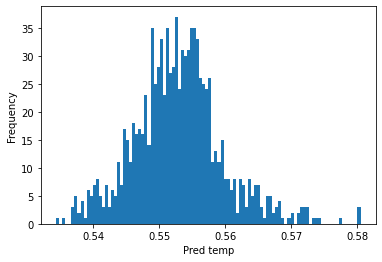

In [ ]:
plt.figure()
plt.hist(predictions[:,0], bins=100)
plt.xlabel('Pred temp')
plt.ylabel('Frequency')
plt.show()

Напишите функцию **stat_intervals(stat, alpha)** для определения доверительного интервала для набора данных **stat** с заданным доверительным уровнем ошибки **alpha** (т.е. если alpha = 0.1, то вероятность того, что искомая величина попадает в доверительный интервал равна 90 %). Функция должна выдавать пару значений: верхнюю и нижнюю границы.

In [ ]:
import scipy
laplas = list( scipy.stats.norm.cdf(np.linspace(0,5,501)) - 0.5 )
for i in range(len(laplas)):
  laplas[i] = float('%.3f'%(laplas[i]))

In [ ]:
def stat_intervals(stat, alpha):
    # Напишите здесь свой код 
    t = laplas.index((1 - alpha)/2)/100
    x = np.mean(stat)
    std = np.std(stat)
    n = len(stat)
    #print(std,':',x,':',np.sqrt(n),':',t)
    boundaries = [x - (std/np.sqrt(n))*t,x + (std/np.sqrt(n))*t]

    return boundaries

Определим доверительный интервал первого спрогнозированного значения для вероятности 95 %.

In [ ]:
interval = stat_intervals(predictions[:,0], 0.05)
interval

[0.5524778298364841, 0.5533182994948549]

Функция **train()** в результате своей работы также выдала результаты прогноза значений температуры на длительный интервал времени. На основании спрогнозированных значений температуры множеством моделей получите для каждого спрогнозированного значения среднее, а также доверительный интервал с уровнем доверия 95 %. Далее постройте график изменения температуры, на котором отразите истинные значения температуры, средние спрогнозированные значения, а также доверительные интервалы.

In [ ]:
alpha = 0.05

means = np.mean( predictions[:,0] )
boundaries = interval
for i in range(1,len(predictions)):
  # Напишите здесь свой код
  means = np.hstack((means, np.mean(predictions[:,i]) ))
  boundaries = np.vstack(( boundaries,stat_intervals(predictions[:,i], alpha) ))

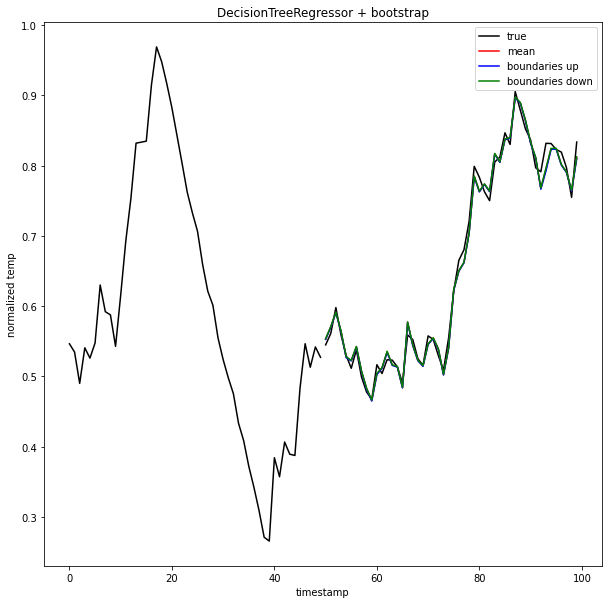

In [ ]:
plt.figure(figsize=(10,10))
length = 50
x1 = np.linspace(start=0, stop=length, num=length, endpoint=False)
x2 = np.linspace(start=length, stop=2*length, num=length, endpoint=False)
plt.plot(x1, y_train[-length:], c='black')
plt.plot(x2, y_test[:length], c='black', label='true')

# Напишите здесь свой код
plt.plot(x2,  means[:length], c='red', label='mean')
plt.plot(x2,  boundaries[:length,0], c='blue', label='boundaries up')
plt.plot(x2,  boundaries[:length,1], c='green', label='boundaries down')

plt.legend()
plt.xlabel('timestamp')
plt.ylabel('normalized temp')
plt.title('DecisionTreeRegressor + bootstrap')
plt.show()

Определите точность усредненного прогноза и сравните его с точностью прогноза одной модели **DecisionTreeRegressor**.

In [ ]:
# Напишите здесь свой код
score_bootstrap_dtr = regr_mape(means, y_test[:1000])

dtr = DecisionTreeRegressor(max_depth=9, min_samples_split=3, min_samples_leaf=2, random_state=0)
results = train(dtr, 'dtr', regr_mape, X_train, y_train, X_test, y_test)
score_dtr = results[1]

print('MAPE for single model: {:.5f}'.format(score_dtr))
print('MAPE for bootstrap model: {:.5f}'.format(score_bootstrap_dtr))

Train model: dtr
score_test = 0.01945
score_train = 0.01334
MAPE for single model: 0.01945
MAPE for bootstrap model: 0.01693


**Выводы:** 

сделайте выводы

In [ ]:
print('MAPE for bootstrap model lesser then MAPE for single model by : {:.5f}'.format(np.abs(score_bootstrap_dtr-score_dtr)))

MAPE for bootstrap model lesser then MAPE for single model by : 0.00252


### Случайный лес

Другой реализацией бэггинга (метода устреднения) является модель под названием "случайный лес", или **RandomForest**. Он может применяться как для решения задачи классификации - [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier "RandomForestClassifier"), так и для решения задачи регрессии - [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor "RandomForestRegressor"). Назван эта модель так, потому что она состоит из нескольких моделей **DecisionTree**, у каждой из которых случайным образом выбраны два параметры: наполнение обучающей выборки и максимальное число используемых признаков. По сути это и есть реализация метода бутстрэп и метода случайного подпространства признаков (о которых речь была выше), но на моделях решающего дерева. Итоговый прогноз получается в результате усреднения прогноза каждой из моделей. За счет рандомизации параметров моделей и их большого числа достигается увеличение качества работы "случайного леса".

Обучите модель **RandomForestRegressor** на тех же данных, что и нашу собственную модель на основе бутсnрэпа. Параметры у модели **RandomForestRegressor** такие же, как и у **DecisionTreeRegressor**, только добавляется **n_estimators** - число простых моделей в итоговой модели, **max_features** - максимальное число признаков, которое будет анализироваться, и **bootstrap** - использовать или нет метод бутстрэпа. Подберите оптимальное значение **n_estimators**, **max_depth**, **min_samples_split**.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#sc_test = list()
#for i in range(2,15):
rf = RandomForestRegressor(
    n_estimators = 28, 
    max_depth = 9, 
    min_samples_split = 6, 
    random_state = 0)
(score_train, score_rf, preds) = train(rf, 'rf', regr_mape, X_bootstrap[0], y_bootstrap[0].flatten(), X_test, y_test)
#  sc_test.append(score_rf)

#print(sc_test.index(np.min(sc_test)))
print('MAPE for RandomForest model: {:.5f}'.format(score_rf))

Train model: rf
score_test = 0.01755
score_train = 0.01032
MAPE for RandomForest model: 0.01755


Обучите модель с оптимальными параметрами, найденными выше. Определите финальное качество прогноза на тестовой выборке. Постройте график прогнозных значений температуры.

In [ ]:
# Напишите здесь свой код
rf = RandomForestRegressor(
    n_estimators = 28, 
    max_depth = 9, 
    min_samples_split = 6, 
    random_state = 0)
(score_train, score_rf, preds) = train(rf, 'rf', regr_mape, X_train, y_train, X_test, y_test)

print('MAPE for RandomForest model: {:.5f}'.format(score_rf))

Train model: rf
score_test = 0.01698
score_train = 0.01254
MAPE for RandomForest model: 0.01698


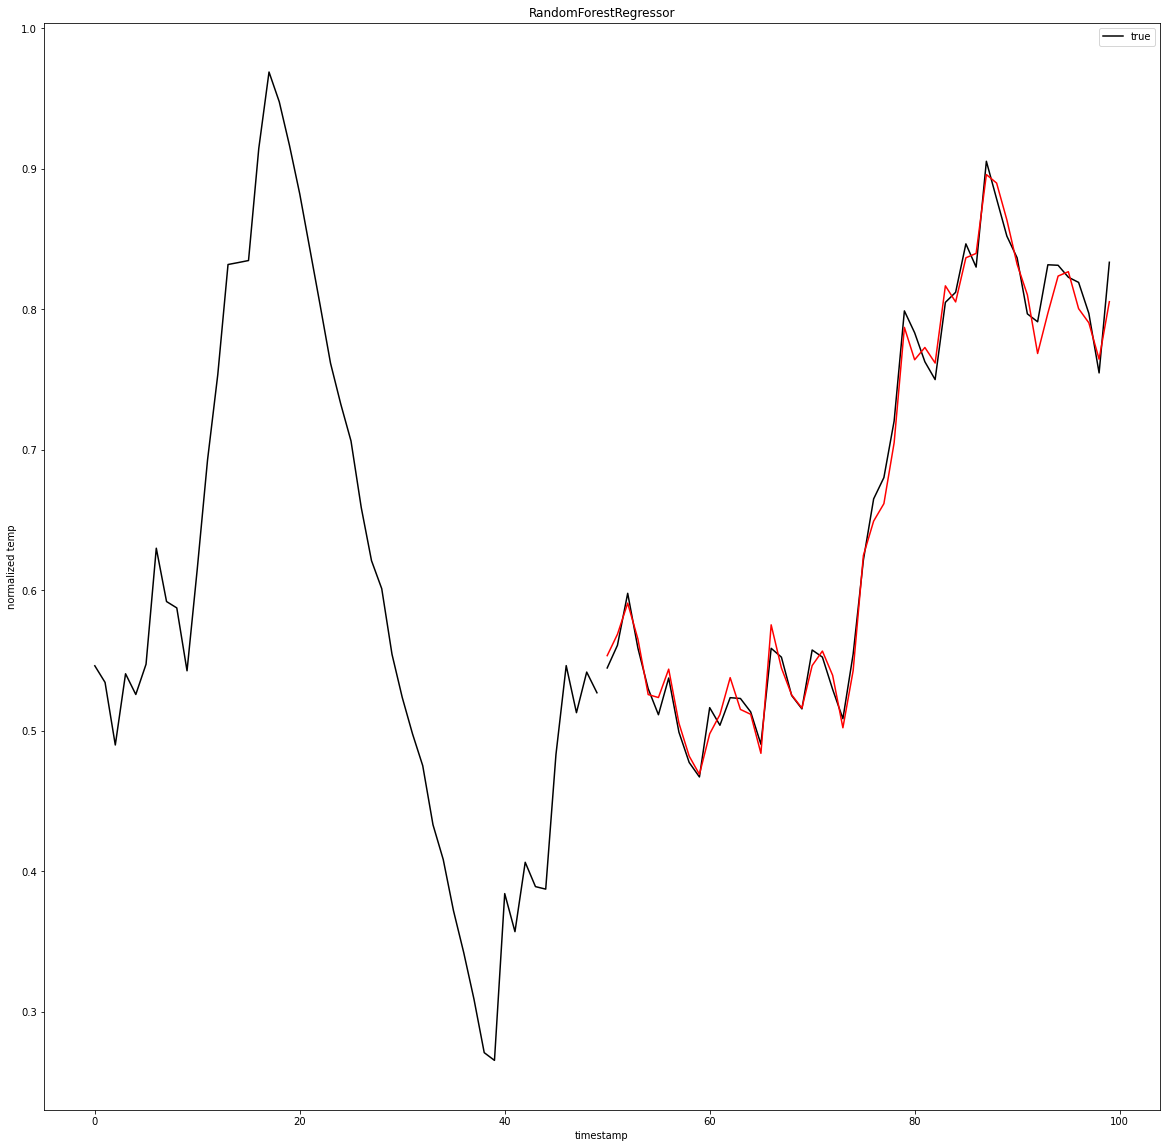

In [ ]:
plt.figure(figsize=(20,20))
length = 50
x1 = np.linspace(start=0, stop=length, num=length, endpoint=False)
x2 = np.linspace(start=length, stop=2*length, num=length, endpoint=False)
plt.plot(x1, y_train[-length:], c='black')
plt.plot(x2, y_test[:length], c='black', label='true')
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('normalized temp')
plt.title('RandomForestRegressor')

# Напишите здесь свой код
plt.plot(x2,  preds[:length], c='red', label='preds')


plt.show()

## Метод бустинга

### AdaBoost

Эта модель является одной из самых популярных реализаций методов бустинга и была разработана в 1995 году Фройндом и Шапиро. Основной принцип AdaBoost состоит в том, чтобы обучить последовательность "слабых" моделей (то есть моделей, которые лишь немного лучше, чем случайный прогноз, такие как небольшие деревья решений) на многократно изменяемых версиях данных. Прогнозы от всех из них затем объединяются посредством взвешенного большинства голосов (или суммы) для получения окончательного прогноза. Модификации данных на каждой так называемой итерации бустинга состоят в применении весов к каждой обучающей выборке. Первоначально все эти веса установлены равными, поэтому на первом этапе просто обучается "слабая" модель на исходных данных. Для каждой последующей итерации веса выборки индивидуально изменяются, и алгоритм обучения повторно применяется к повторно взвешенным данным. На данном этапе те обучающие примеры, которые были неправильно предсказаны усиленной моделью, созданной на предыдущем шаге, имеют увеличенные веса, тогда как веса уменьшаются для тех, которые были предсказаны правильно. По мере продолжения итераций, примеры, которые трудно предсказать, получают все большее влияние. Таким образом, каждая последующая "слабая" модель вынуждена концентрироваться на примерах, которые упускают предыдущие модели. 

Модель AdaBoost позволяет решать как задачи классификации, так и задачи регрессии. Создайте объект [**AdaBoostRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor "AdaBoostRegressor"). Параметр **base_estimator** задает "слабую" модель, которая будет использоваться для бустинга, **n_estimators** обозначает число "слабых" моделей в последовательности. Параметр **learning_rate** определяет вес, на который домножаются примеры из обучающей выборки. Этот параметр очень важен и играет роль регуляризации: чем он меньше, тем медленнее идет обучение, но тем "лучше" оно проходит. Наконец параметр **loss** определяет функцию (она называется функция потерь), по которой на каждой итерации бустинга рассчитывается штраф за неверно предсказанное значение и определяются веса, на которые нужно домножить примеры из обучающей выборки на следующей итерации бустинга. Доступные функции потерь - линейная, квадратичная и экспоненциальная.

Обучите модель AdaBoost на двух "слабых" моделях: решающее дерево (с оптимальными параметрами, найденными выше) и линейная регрессия. Подберите оптимальным образом параметры **learning_rate** и **n_estimators** Определите качество прогноза на тех же самых тестовых данных, что и выше.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

dtr = DecisionTreeRegressor(max_depth=10, min_samples_split=2, random_state=0)
lr = LinearRegression()

In [ ]:
# Напишите здесь свой код
l_r_sc_adaboost_dtr = list()
l_r_sc_adaboost_lr = list()

n_e_sc_adaboost_dtr = list()
n_e_sc_adaboost_lr = list()

#learning_rate------------------------------
learning_rate = [0.0001,0.001,0.01,0.1,1]
for l_r in learning_rate:
  adaboost_dtr = AdaBoostRegressor(
          base_estimator = dtr,
          n_estimators = 50, 
          learning_rate = l_r, 
          random_state = 0)
  (score_train, score_adaboost_dtr, preds_adaboost_dtr) = train(adaboost_dtr, 'adaboost_dtr', regr_mape, X_train, y_train, X_test, y_test)
  l_r_sc_adaboost_dtr.append(score_adaboost_dtr)

  adaboost_lr = AdaBoostRegressor(
          base_estimator = lr,
          n_estimators = 50,
          learning_rate = l_r, 
          random_state = 0)  
  
  (score_train, score_adaboost_lr, preds_adaboost_lr) = train(adaboost_lr, 'adaboost_lr', regr_mape, X_train, y_train, X_test, y_test)  
  l_r_sc_adaboost_lr.append(score_adaboost_lr)

l_rdtr = learning_rate[l_r_sc_adaboost_dtr.index(np.min(l_r_sc_adaboost_dtr))]
l_rlr = learning_rate[l_r_sc_adaboost_lr.index(np.min(l_r_sc_adaboost_lr))]
#n_estimators--------------------------------------
for i in range(1,25):
  adaboost_dtr = AdaBoostRegressor(
          base_estimator = dtr,
          n_estimators = i, 
          learning_rate = l_rdtr, 
          random_state = 0)
  (score_train, score_adaboost_dtr, preds_adaboost_dtr) = train(adaboost_dtr, 'adaboost_dtr', regr_mape, X_train, y_train, X_test, y_test)
  n_e_sc_adaboost_dtr.append(score_adaboost_dtr)

  adaboost_lr = AdaBoostRegressor(
          base_estimator = lr,
          n_estimators = i,
          learning_rate = l_rlr, 
          random_state = 0) 
  (score_train, score_adaboost_lr, preds_adaboost_lr) = train(adaboost_lr, 'adaboost_lr', regr_mape, X_train, y_train, X_test, y_test)  
  n_e_sc_adaboost_lr.append(score_adaboost_lr)

Train model: adaboost_dtr
score_test = 0.01684
score_train = 0.00846
Train model: adaboost_lr
score_test = 0.03369
score_train = 0.03438
Train model: adaboost_dtr
score_test = 0.01689
score_train = 0.00840
Train model: adaboost_lr
score_test = 0.03371
score_train = 0.03439
Train model: adaboost_dtr
score_test = 0.01675
score_train = 0.00837
Train model: adaboost_lr
score_test = 0.03387
score_train = 0.03453
Train model: adaboost_dtr
score_test = 0.01668
score_train = 0.00805
Train model: adaboost_lr
score_test = 0.03588
score_train = 0.03648
Train model: adaboost_dtr
score_test = 0.01646
score_train = 0.00759
Train model: adaboost_lr
score_test = 0.03769
score_train = 0.03829
Train model: adaboost_dtr
score_test = 0.02130
score_train = 0.01407
Train model: adaboost_lr
score_test = 0.03395
score_train = 0.03444
Train model: adaboost_dtr
score_test = 0.02130
score_train = 0.01407
Train model: adaboost_lr
score_test = 0.03395
score_train = 0.03444
Train model: adaboost_dtr
score_test = 0.

In [ ]:
# Напишите здесь свой код
adaboost_dtr = AdaBoostRegressor(
        base_estimator = dtr,
        n_estimators = n_e_sc_adaboost_dtr.index(np.min(n_e_sc_adaboost_dtr))+1, 
        learning_rate = learning_rate[l_r_sc_adaboost_dtr.index(np.min(l_r_sc_adaboost_dtr))], 
        random_state = 0)
adaboost_lr = AdaBoostRegressor(
        base_estimator = lr,
        n_estimators = n_e_sc_adaboost_lr.index(np.min(n_e_sc_adaboost_lr))+1,
        learning_rate = learning_rate[l_r_sc_adaboost_lr.index(np.min(l_r_sc_adaboost_lr))], 
        random_state = 0)
(score_train, score_adaboost_dtr, preds_adaboost_dtr) = train(adaboost_dtr, 'adaboost_dtr', regr_mape, X_train, y_train, X_test, y_test)
(score_train, score_adaboost_lr, preds_adaboost_lr) = train(adaboost_lr, 'adaboost_lr', regr_mape, X_train, y_train, X_test, y_test)

print('MAPE for AdaBoost on DecisionTree model: {:.5f}'.format(score_adaboost_dtr))
print('MAPE for AdaBoost on LinearRegression model: {:.5f}'.format(score_adaboost_lr))

Train model: adaboost_dtr
score_test = 0.01656
score_train = 0.00791
Train model: adaboost_lr
score_test = 0.03367
score_train = 0.03438
MAPE for AdaBoost on DecisionTree model: 0.01656
MAPE for AdaBoost on LinearRegression model: 0.03367


Постройте сравнительный график прогнозных значений температуры обоих моделей.

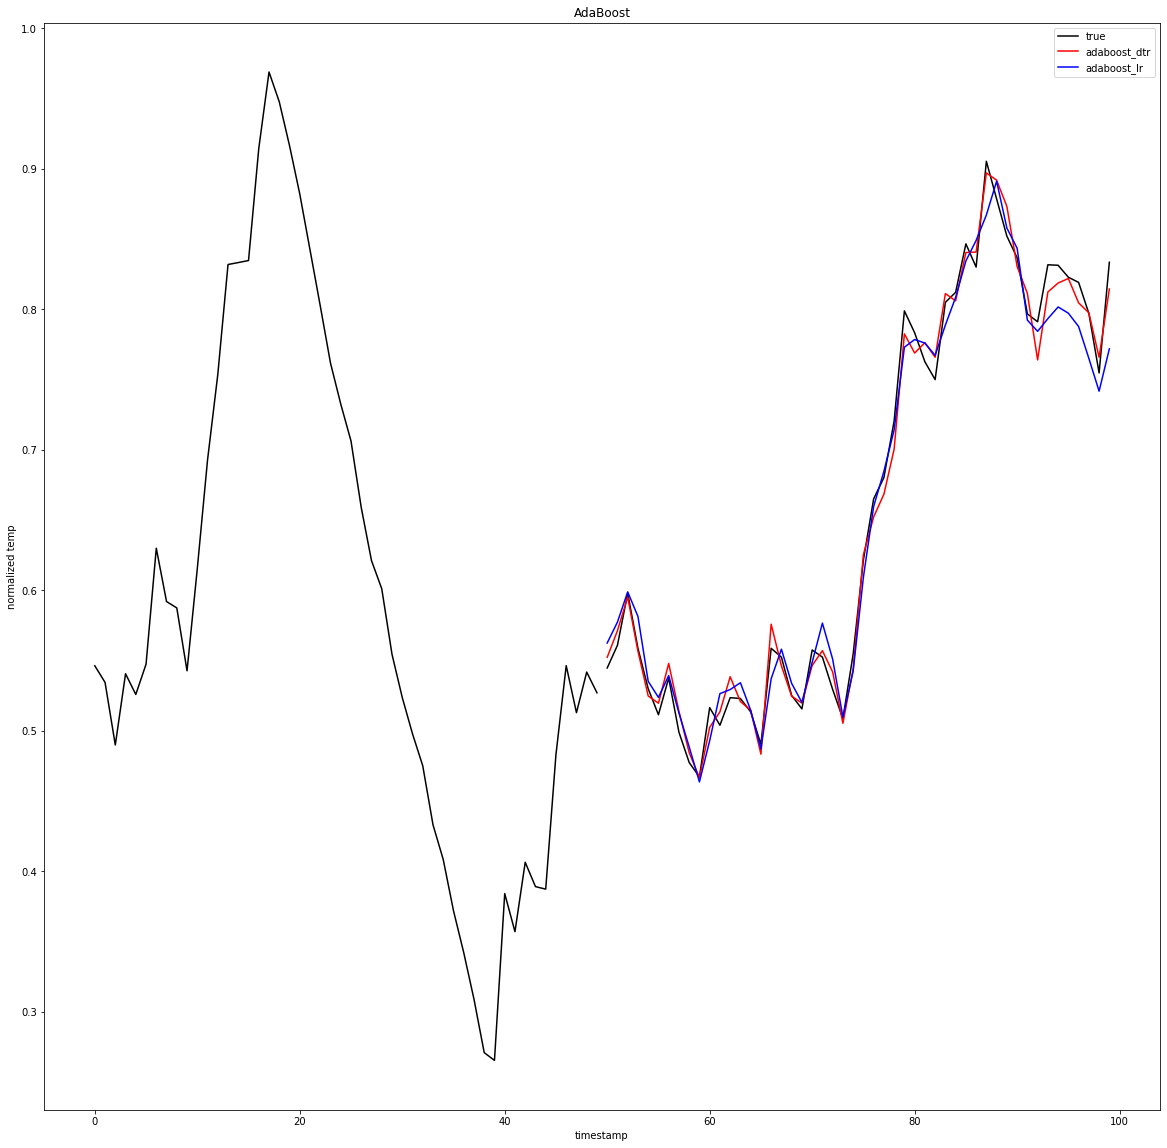

In [ ]:
plt.figure(figsize=(20,20))
length = 50
x1 = np.linspace(start=0, stop=length, num=length, endpoint=False)
x2 = np.linspace(start=length, stop=2*length, num=length, endpoint=False)
plt.plot(x1, y_train[-length:], c='black')
plt.plot(x2, y_test[:length], c='black', label='true')


# Напишите здесь свой код
plt.plot(x2,  preds_adaboost_dtr[:length], c='red', label='adaboost_dtr')
plt.plot(x2,  preds_adaboost_lr[:length], c='blue', label='adaboost_lr')
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('normalized temp')
plt.title('AdaBoost')
plt.show()

**Выводы:**

сделайте выводы

In [ ]:
print('MAPE for AddaBoost with dtr lesser then MAPE for AddaBoost with lr by: {:.5f}'.format(np.abs(score_adaboost_dtr-score_adaboost_lr)))

MAPE for AddaBoost with dtr lesser then MAPE for AddaBoost with lr by: 0.01711


In [ ]:
print('lr : n_estimators =',n_e_sc_adaboost_lr.index(np.min(n_e_sc_adaboost_lr))+1 , ' learning_rate =',learning_rate[l_r_sc_adaboost_lr.index(np.min(l_r_sc_adaboost_lr))])
print('dtr : n_estimators =',n_e_sc_adaboost_dtr.index(np.min(n_e_sc_adaboost_dtr))+1 , ' learning_rate =',learning_rate[l_r_sc_adaboost_dtr.index(np.min(l_r_sc_adaboost_dtr))])

lr : n_estimators = 24  learning_rate = 0.0001
dtr : n_estimators = 24  learning_rate = 1


### Gradient Tree Boosting

В модели **AdaBoost** есть возможность выбора функции потерь, которая определяет каким образом будут распределены веса между примерами из обучающей выборки на следующей итерации бустинга, - линеная, квадратичная или экспоненциальная. Градиентный бустинг на решающих деревьях (Gradient Tree Boosting или **Gradient Boosted Decision Tree, GBDT**) - это обобщение на случай произвольных дифференцируемых функций потерь. **GBDT** - это эффективная модель процедура, которую можно использовать для решения задач регрессии и классификации в различных областях, включая ранжирование в веб-поиске и экологию.

Идея **GBDT** состоит в следующем. Итоговая модель представляет собой линеную комбинацию "слабых" моделей - решающих деревьев:

$$
F_M(x) = \sum^M_{m=1}h_m(x)
$$

На каждой итерации бустинга к итоговой модели добавляется новое решающее дерево:

$$
F_m(x) = F_{m-1}(x) + h_m(x),
$$

которое выбирается таким образом, чтобы минимизировать ошибку прогноза, т.е. функцию потерь $L(y, F(x))$, уже построенной к этой итерации модели:

$$
h_m = argmin_{h}L_m = argmin_h\sum^N_{i=1}L(y_i, F_{m-1}(x_i) + h(x_i))
$$

Построение этого нового решающего дерева ведется методом градиентного спуска для минимизации функции потерь:

$$
h_m \approx argmin_h\sum^N_{i=1}h(x_i)g_i, \quad g_i = \left.\dfrac{\partial L(y_i,F(x_i))}{\partial F(x_i)}\right|_{F=F_{m-1}}.
$$

Постройте и обучите модель градиентного бустинга из пакета **LightGBM** - [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor "LGbMRegressor"). Эта реализации работает сильно быстрее по сравнению с реализацией в пакете Sklearn [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor "GradientBoostingRegressor"). Параметры этой модели те же самые, что и у **AdaBoost**.

Подберите оптимальным образом параметры num_leaves, max_depth, learning_rate и n_estimators. Оцените качетсво работы модели на том же тестовом датасете, что и предыдующие модели.

In [ ]:
!pip install lightgbm

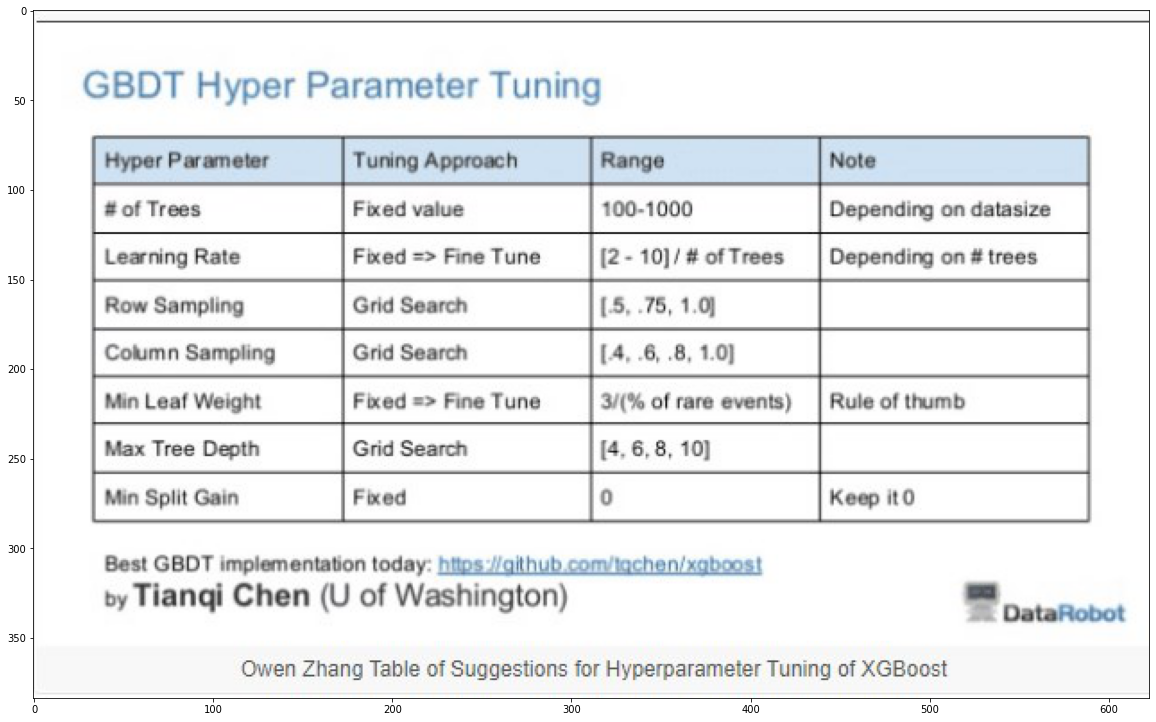

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
img = mpimg.imread('GBDT_hip_params.jpg')
imgplot = plt.imshow(img)
plt.show()


In [ ]:
from lightgbm import LGBMRegressor

l_GDBT = list()
d_GDBT = list()
l_r_GDBT = list()
n_e_GDBT = list()


# Напишите здесь свой код
for i in range(100,200):
  lgbm = LGBMRegressor(num_leaves = 35, 
                      max_depth = 6, 
                      learning_rate = 0.03, 
                      n_estimators = i, 
                      random_state = 0)
  (score_train, score_lgbm, preds_lgbm) = train(lgbm, 'lgbm', regr_mape, X_train, y_train, X_test, y_test)
  n_e_GDBT.append(score_lgbm)
  #print('MAPE for LightGBM: {:.5f}'.format(score_lgbm))
trees = n_e_GDBT.index(np.min(n_e_GDBT))+100

learning_rate = np.linspace(2/trees,4/trees,10)
for l_r in learning_rate:
  lgbm = LGBMRegressor(num_leaves = 35, 
                      max_depth = 6, 
                      learning_rate = l_r, 
                      n_estimators = trees,
                      random_state = 0)
  (score_train, score_lgbm, preds_lgbm) = train(lgbm, 'lgbm', regr_mape, X_train, y_train, X_test, y_test)
  l_r_GDBT.append(score_lgbm)
  #print('MAPE for LightGBM: {:.5f}'.format(score_lgbm))
l_r = learning_rate[l_r_GDBT.index(np.min(l_r_GDBT))]

dp = [4,6,8,10]
for i in dp:
  lgbm = LGBMRegressor(num_leaves = 35, 
                      max_depth = i, 
                      learning_rate = l_r, 
                      n_estimators = trees, 
                      random_state = 0)
  (score_train, score_lgbm, preds_lgbm) = train(lgbm, 'lgbm', regr_mape, X_train, y_train, X_test, y_test)
  d_GDBT.append(score_lgbm)
  #print('MAPE for LightGBM: {:.5f}'.format(score_lgbm))
depth = dp[d_GDBT.index(np.min(d_GDBT))]

for i in range(15,40):
  lgbm = LGBMRegressor(num_leaves = i, 
                      max_depth = depth, 
                      learning_rate = l_r, 
                      n_estimators = trees, 
                      random_state = 0)
  (score_train, score_lgbm, preds_lgbm) = train(lgbm, 'lgbm', regr_mape, X_train, y_train, X_test, y_test)
  l_GDBT.append(score_lgbm)  
  #print('MAPE for LightGBM: {:.5f}'.format(score_lgbm))
leaves = l_GDBT.index(np.min(l_GDBT))+15

Train model: lgbm
score_test = 0.02124
score_train = 0.02074
Train model: lgbm
score_test = 0.02102
score_train = 0.02050
Train model: lgbm
score_test = 0.02081
score_train = 0.02027
Train model: lgbm
score_test = 0.02062
score_train = 0.02006
Train model: lgbm
score_test = 0.02043
score_train = 0.01986
Train model: lgbm
score_test = 0.02024
score_train = 0.01966
Train model: lgbm
score_test = 0.02008
score_train = 0.01947
Train model: lgbm
score_test = 0.01994
score_train = 0.01930
Train model: lgbm
score_test = 0.01978
score_train = 0.01912
Train model: lgbm
score_test = 0.01963
score_train = 0.01897
Train model: lgbm
score_test = 0.01949
score_train = 0.01881
Train model: lgbm
score_test = 0.01937
score_train = 0.01866
Train model: lgbm
score_test = 0.01925
score_train = 0.01851
Train model: lgbm
score_test = 0.01913
score_train = 0.01838
Train model: lgbm
score_test = 0.01902
score_train = 0.01825
Train model: lgbm
score_test = 0.01892
score_train = 0.01813
Train model: lgbm
score_

In [ ]:
print('n_estimators=',trees,'  learning_rate=',l_r,'  max_depth=',depth,'  num_leaves=',leaves)

n_estimators= 199   learning_rate= 0.020100502512562814   max_depth= 10   num_leaves= 39


In [ ]:
# Напишите здесь свой код
lgbm = LGBMRegressor(num_leaves = leaves, 
                     max_depth = depth, 
                     learning_rate = l_r, 
                     n_estimators = trees, 
                     random_state = 0)
(score_train, score_lgbm, preds_lgbm) = train(lgbm, 'lgbm', regr_mape, X_train, y_train, X_test, y_test)

print('MAPE for LightGBM: {:.5f}'.format(score_lgbm))

Train model: lgbm
score_test = 0.01731
score_train = 0.01609
MAPE for LightGBM: 0.01731


Постройте график прогнозных значений температуры.

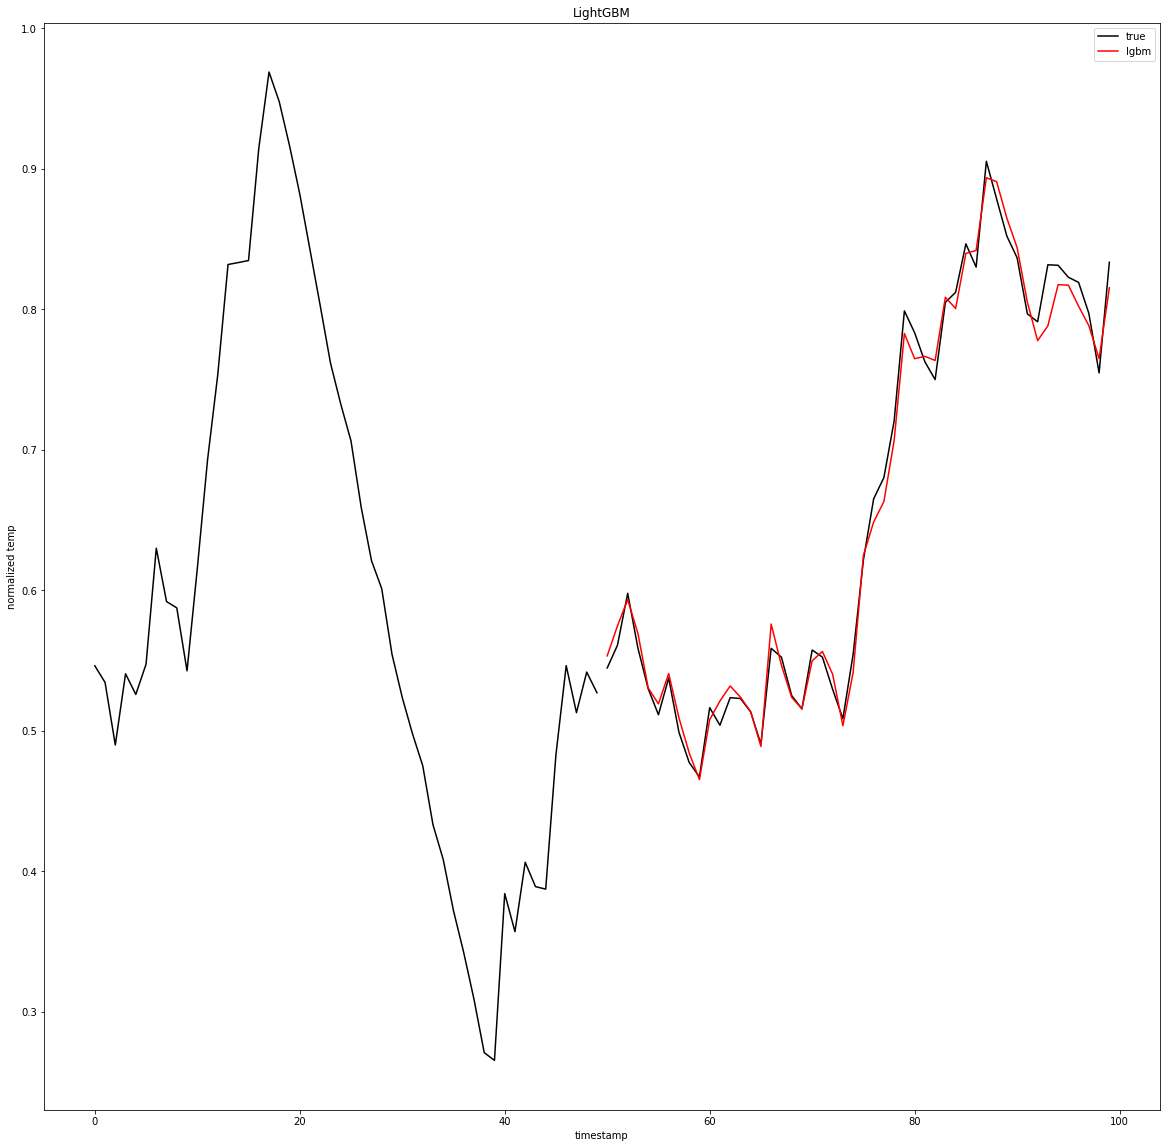

In [ ]:
plt.figure(figsize=(20,20))
length = 50
x1 = np.linspace(start=0, stop=length, num=length, endpoint=False)
x2 = np.linspace(start=length, stop=2*length, num=length, endpoint=False)
plt.plot(x1, y_train[-length:], c='black')
plt.plot(x2, y_test[:length], c='black', label='true')


# Напишите здесь свой код
plt.plot(x2,  preds_lgbm[:length], c='red', label='lgbm')
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('normalized temp')
plt.title('LightGBM')

plt.show()

## Сравнение различных методов и моделей

Постройте для сравнения на одной гистограмме качество проанализированных моделей на тестовой выборке: обычное решающее дерево, решающее дерево с бутстрэпом, случайный лес, AdaBoost на линейной регрессии, AdaBoost на решающем дереве, градиентный бустинг на решающих деревьях LightGBM. Сделайте выводы.

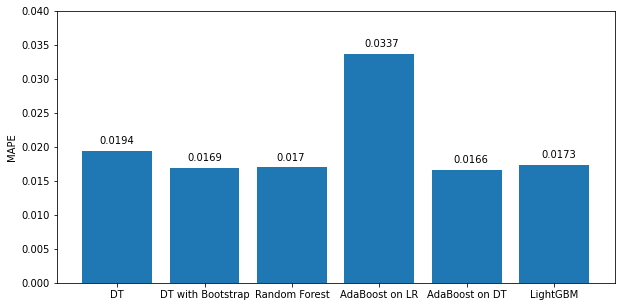

In [ ]:
plt.figure(figsize=(10,5))
xx = ['DT', 'DT with Bootstrap', 'Random Forest', 'AdaBoost on LR', 'AdaBoost on DT', 'LightGBM']
yy = [score_dtr, score_bootstrap_dtr, score_rf, score_adaboost_lr, score_adaboost_dtr, score_lgbm]
rects = plt.bar(xx, yy)
plt.ylim(0, 0.04)
plt.ylabel('MAPE')
for i, rect in enumerate(rects):
    yloc = rect.get_height()
    xloc = rect.get_x() + rect.get_width() / 4
    plt.annotate(round(yy[i], 4), xy=(xloc, yloc), xytext=(xloc, 10),
                            textcoords="offset points",
                            va='center',
                            color='black', clip_on=True)

**Выводы:**

сделайте выводы

In [ ]:
print('Самая точная модель - ',xx[yy.index(min(yy))] ,' ',(1-min(yy))*100,'%',' MAPE=',min(yy))

Самая точная модель -  AdaBoost on DT   98.34408665687839 %  MAPE= 0.01655913343121604


In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 654.426456451416 seconds ---
